In [1]:
%matplotlib inline

import os
import numpy as np
import pandas as pd
import rasterio as rio
import fiona as fio
from fiona.crs import from_epsg
from pyproj import Proj, transform
import matplotlib.pyplot as plt

# read additional scripts
from scripts.clip_area import clip_area
from scripts.read_landsat_images import read_landsat_images
from scripts.show_band import show_band

In [2]:
def prepare_directories(main_folder):
    """Function prepares list with Landsat images directories in the given folder."""
    raw_list = os.listdir(main_folder)
    prepared_list = []
    for folder in raw_list:
        if ((folder.startswith('LC')) and not (folder.endswith('.tar.gz'))):
            prepared_list.append(main_folder + '/' + folder + '/')
    return prepared_list

def read_timestamp(folder):
    """Function reads date of acquisition of each Landsat 8 scene based on the folder with MTL file."""
    files = os.listdir(folder)
    for file in files:
        if file.startswith('LC') and file.endswith('MTL.txt'):
            address = folder + '/' + file
            with open(address, 'r') as f:
                for line in f:
                    line = ''.join(line.split())
                    if line.startswith('DATE_ACQUIRED='):
                        line = line.replace('DATE_ACQUIRED=', '')
                        return line

def prepare_dataframe(folders):
    """Function prepares dataframe with index column as a date of acquisition and the main column DIR which points
    to the directories with Landsat 8 images. Function takes one argument: the list of folders with Landsat 8 datasets."""
    
    # DataFrame preparation
    time_series = pd.DataFrame(folders, columns=['DIR'])
    time_series.index = time_series['DIR'].apply(lambda x: str(pd.to_datetime(read_timestamp(x)).date()))
    time_series.index.name = 'DATE'
    time_series = time_series.sort_index()
    return time_series

folder = 'data/rasters'
dataset = prepare_directories(folder)
dataset = prepare_dataframe(dataset)
dataset

,DIR
DATE,
2013-04-15,data/rasters/LC081900222013041501T1-SC20180614...
2013-05-01,data/rasters/LC081900222013050101T1-SC20180614...
2013-05-17,data/rasters/LC081900222013051701T1-SC20180614...
2013-06-18,data/rasters/LC081900222013061801T1-SC20180614...
2013-08-05,data/rasters/LC081900222013080501T1-SC20180614...
2013-09-06,data/rasters/LC081900222013090601T1-SC20180614...
2014-07-07,data/rasters/LC081900222014070701T1-SC20180614...
2015-04-21,data/rasters/LC081900222015042101T1-SC20180614...
2015-08-11,data/rasters/LC081900222015081101T1-SC20180614...


In [3]:
# Prepare Area of Interest

def get_epsg_from_raster(raster_address):
    """Function reads raster data and gets its coordinate reference system. 
    Then it is converted to the European Petroleum Survey Group (EPSG) reference number."""
    with rio.open(raster_address) as f:
        band_crs = f.crs
        destination_epsg = band_crs['init'][5:]
        destination_epsg = int(destination_epsg)
    return destination_epsg

class VectorData:
    """Class reads, stores, shows and reprojects vector shapefiles.
    It is initialized with filename.
    
    Class methods:
    get_vector_data(parameters='all', write_params=True) - method reads vector data and parse its parameters such as geometry,
    properties, crs and schema into dictionaries. Method may store parameters inside the object if write_params is set
    to True. Method returns desired parameters.
    reproject_geometry(destination_epsg, update=False) - method changes projection of each point inside the Polygon into
    projection given as an epsg number. It may update object geometry if the update parameter is set to True. Method returns
    reprojected geometry dictionary.
    show_vector_data(geometry=None) - method shows polygon. If geometry is not given then method uses class geometry."""
    
    def __init__(self, filename):
        self.v_file = filename
        self.geometry = {}
        self.properties = None
        self.vec_crs = None
        self.vec_schema = None
        
    def get_vector_data(self, parameters='all', write_params=True):
        """
        Function reads vector and its parameters and return them and / or store them inside the objects instance.
        input 1: parameters (string)
        parameters: 'all', 'none', 'geometry', 'properties', 'crs', 'schema'
        'all': returns tuple with geometry, properties, crs and schema;
        'none': does not return anything;
        'geometry', 'properties', 'crs' or 'schema': returns chosen parameter.
        input 2: write_params (bool)
        write_params: True, False
        True: store all parameters in the object
        False: do not store anything in the object
        output: chosen parameters as a dict"""
        
        with fio.open(vector_file, 'r') as masking_region:
            geometry = [feature["geometry"] for feature in masking_region]
            properties = [feature['properties'] for feature in masking_region]
            vec_crs = masking_region.crs
            vec_schema = masking_region.schema
        
        if write_params:
            print('--- Object geometry, properties, crs and schema updated ---')
            self.geometry = geometry
            self.properties = properties
            self.vec_crs = vec_crs
            self.vec_schema = vec_schema
        else:
            print('--- Object parameters not updated ---')
            
        output_dict = {'all': ({'geometry': geometry, 'properties': properties, 'crs': vec_crs, 'scheme': vec_schema}),
                      'none': 0,
                      'geometry': geometry,
                      'properties': properties,
                      'crs': vec_crs,
                      'schema': vec_schema}
        try:
            return output_dict[parameters]
        except KeyError:
            raise KeyError("Parameter not available. Available parameters: 'all', 'none', 'geometry', 'properties', 'crs', 'schema'")
      
    def reproject_geometry(self, destination_epsg, update=False):
        """
        Function reprojects vector geometry and may update objects geometry.
        input 1: destination_epsg (string or int)
        input 2: update (bool)
        True: update object's geometry
        False: do not update object's geometry
        output: reprojected geometry as a dict"""
        
        try:
            destination_crs = from_epsg(destination_epsg)
            proj_crs_in = Proj(self.vec_crs)
            coordinates_list = self.geometry[0]['coordinates'][0]
        except RuntimeError:
            raise ValueError('Given EPSG is wrong or it is not stored in fiona to run from_epsg method')
        except KeyError:
            raise ValueError('You must update your object parameters by get_vector_data method with write_params set to True.')
        proj_crs_out = Proj(init = destination_crs['init'])
        coordinates_array = np.asarray(coordinates_list)
        projected_g = []
        
        for g in coordinates_array:
            transformed = transform(proj_crs_in, proj_crs_out, g[0], g[1])
            points = (transformed[0], transformed[1],)
            projected_g.append(points)
        geometry_dict = {'coordinates': [projected_g], 'type': 'Polygon'}
        
        if update:
            self.geometry = [geometry_dict]
            
        return [geometry_dict]
    
    def show_vector_data(self, geometry=None):
        """
        Function shows vector geometry.
        input 1: geometry (dict, geometry retrieved as a parameter from the vector data type).
        If geometry is not given then method takes it from the objects instance."""
        
        if geometry:
            g = geometry
        else:
            g = self.geometry
            
        try:
            coordinates_list = g[0]['coordinates'][0]
        except KeyError:
            raise ValueError(
                'Geometry is not defined. Please, update geometry with get_vector_data method or provide valid geometry object to the method.')
            
        coordinates_array = np.asarray(coordinates_list)
        plt.figure()
        plt.plot(coordinates_array[:, 0], coordinates_array[:, 1])
        plt.show()

--- Object geometry, properties, crs and schema updated ---


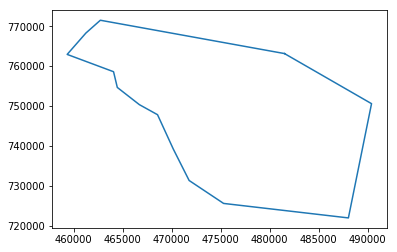

In [4]:
# Read and show county

vector_file = 'data/vector/zatoka_gdanska.shp'
vector_data = VectorData(vector_file)
vd = vector_data.get_vector_data('geometry', True)
vector_data.show_vector_data(vd)

In [5]:
landsat_images = read_landsat_images(dataset['DIR'][2])
landsat_images

{1: 'data/rasters/LC081900222013051701T1-SC20180614120419/LC08_L1TP_190022_20130517_20180301_01_T1_sr_band1.tif',
 2: 'data/rasters/LC081900222013051701T1-SC20180614120419/LC08_L1TP_190022_20130517_20180301_01_T1_sr_band2.tif',
 3: 'data/rasters/LC081900222013051701T1-SC20180614120419/LC08_L1TP_190022_20130517_20180301_01_T1_sr_band3.tif',
 4: 'data/rasters/LC081900222013051701T1-SC20180614120419/LC08_L1TP_190022_20130517_20180301_01_T1_sr_band4.tif',
 5: 'data/rasters/LC081900222013051701T1-SC20180614120419/LC08_L1TP_190022_20130517_20180301_01_T1_sr_band5.tif',
 6: 'data/rasters/LC081900222013051701T1-SC20180614120419/LC08_L1TP_190022_20130517_20180301_01_T1_sr_band6.tif',
 7: 'data/rasters/LC081900222013051701T1-SC20180614120419/LC08_L1TP_190022_20130517_20180301_01_T1_sr_band7.tif'}

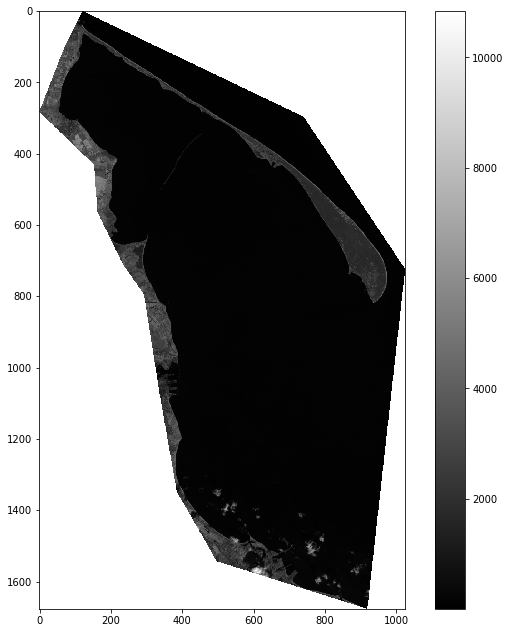

In [6]:
epsg = get_epsg_from_raster(landsat_images[5])
vn = vector_data.reproject_geometry(epsg, True)
file_for_clipped = 'data/clipped/clip_test.tif'
clip_area(vn, landsat_images[5], file_for_clipped)
with rio.open(file_for_clipped) as f:
    band = f.read(1)
    band_crs = f.crs
    
show_band(band)

In [73]:
class PixelQA:
    
    def __init__(self, data_folder):
        
        # prepare qa file address
        file_list = os.listdir(data_folder)
        for f in file_list:
            if (f.startswith('LC') and f.endswith('pixel_qa.tif')):
                self.bqa_file = data_folder + f
        
        # prepare qa band
        with rio.open(self.bqa_file) as f:
            self.qa_band = f.read(1)
            
        # Dictionary with cloud pixel values for pixel_qa band 
        # (https://landsat.usgs.gov/landsat-surface-reflectance-quality-assessment)
        self.clouds = {'Cloud Shadow': [328, 392, 840, 904, 1350],
                      'Cloud': [352, 368, 416, 432, 480, 864, 880, 928, 944, 992],
                      'Cloud confidence': {'Low': [322, 324, 328, 336, 352, 368, 834, 836, 840, 848, 864, 880],
                                           'Medium': [386, 388, 392, 400, 416, 432, 900, 904, 928, 944],
                                           'High': [480, 992]},
                      'Cirrus confidence': {'Low': [322, 324, 328, 336, 352, 368, 386, 388, 392, 400, 416, 432, 480],
                                           'High': [834, 836, 840, 848, 864, 880, 898, 900, 904, 912, 928, 944, 992]}}
        
    def prepare_values(self, clear_key):
        values = {'object': [self.clouds['Cloud Shadow'], self.clouds['Cloud']],
                 'Cloud Shadow': [self.clouds['Cloud Shadow']],
                 'Cloud': [self.clouds['Cloud']],
                 'Cloud low': [self.clouds['Cloud confidence']['Low'],
                               self.clouds['Cloud confidence']['Medium'],
                               self.clouds['Cloud confidence']['High']],
                 'Cloud medium': [self.clouds['Cloud confidence']['Medium'],
                                  self.clouds['Cloud confidence']['High']],
                 'Cloud high': [self.clouds['Cloud confidence']['High']],
                 'Cirrus low': [self.clouds['Cirrus confidence']['Low'],
                                self.clouds['Cirrus confidence']['High']],
                 'Cirrus high': [self.clouds['Cirrus confidence']['High']]}
        values_to_remove = values[clear_key]
        
        if len(values_to_remove) > 1:
            vals = []
            for values_list in values_to_remove:
                vals = vals + values_list
        else:
            vals = values_to_remove[0]
        return vals
    
    def clear_pixels(self, band, qa_input = None, clear_by='object', nofill_value=0.0):
        values_to_remove = self.prepare_values(clear_by)
        if qa_input is None:
            qa_channel = self.qa_band
        else:
            qa_channel = qa_input
        for val in values_to_remove:
            qa_channel[qa_channel==val] = nofill_value
        qa_channel[qa_channel > 0] = 1
        output_band = band * qa_channel
        return output_band

In [74]:
a = PixelQA('data/rasters/LC081900222013051701T1-SC20180614120419/')

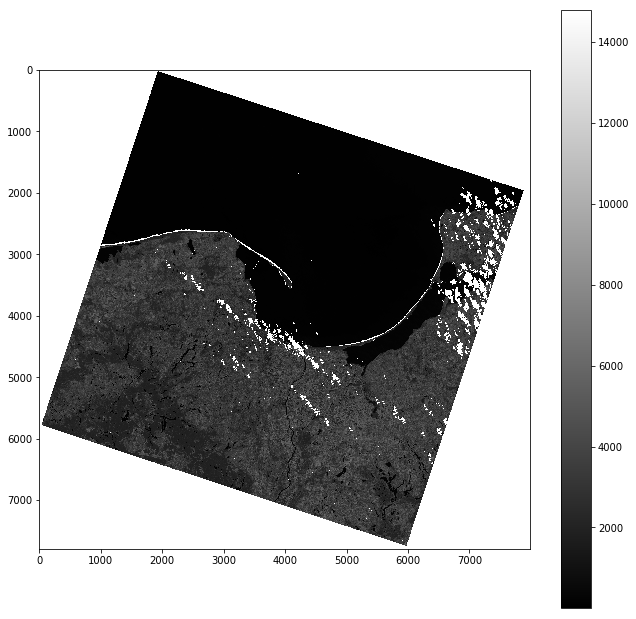

In [75]:
with rio.open(landsat_images[5]) as band:
    numpy_band = band.read(1)

z = a.clear_pixels(numpy_band)
show_band(z)

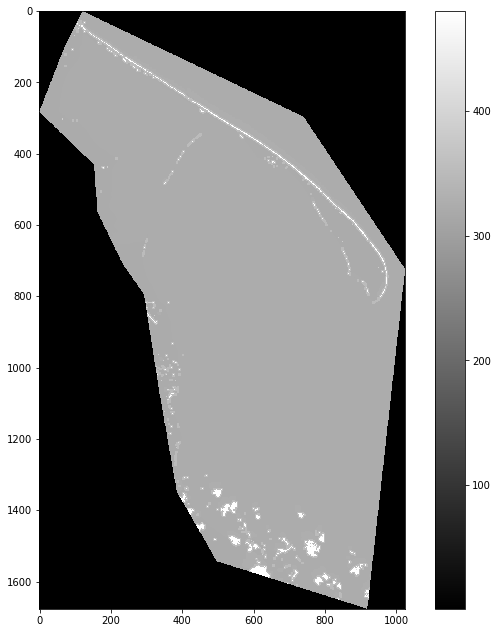

In [76]:
# Preparation of clipped data

file_for_clipped = 'data/clipped/clipped_test.tif'
clip_area(vn, a.bqa_file, file_for_clipped)
with rio.open(file_for_clipped) as f:
    bq_band = f.read(1)
    bq_band_crs = f.crs
    
show_band(bq_band)

In [77]:
file_for_clipped = 'data/clipped/clipped_test.tif'
clip_area(vn, landsat_images[5], file_for_clipped)
with rio.open(file_for_clipped) as f:
    l_band = f.read(1)
    l_band_crs = f.crs

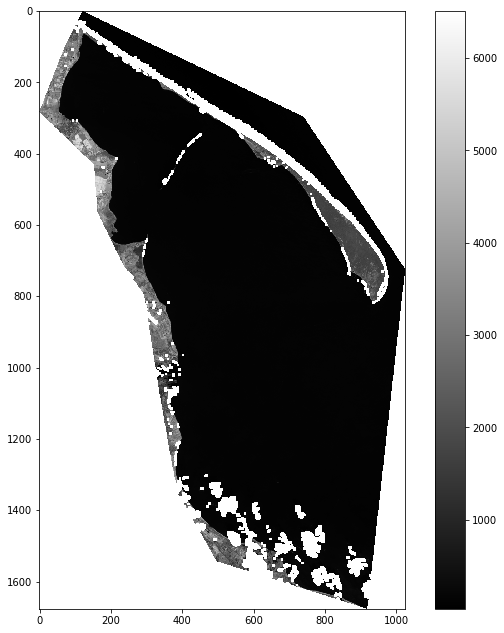

In [78]:
output = a.clear_pixels(l_band, qa_input=bq_band)
show_band(output)